In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import json
import numpy as np
import math
from nltk import word_tokenize
import torchtext
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


141
34
10.12


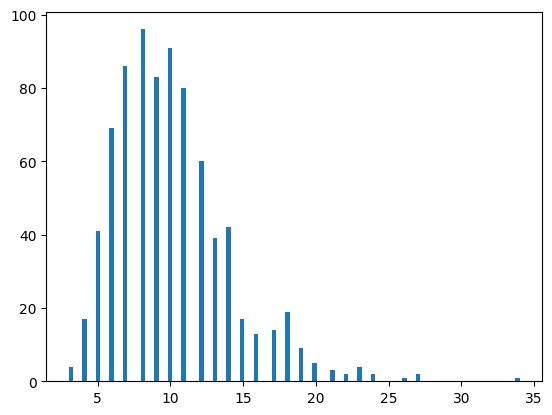

In [98]:
# find the largest sentence length
sent_max_len = 0
max_sent_count = 0
tot_sent_count = 0
num_docs = 0
sent_counts = []
with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        num_docs += 1
        sent_count = len(data['sentences'])
        sent_counts.append(sent_count)
        max_sent_count = max(max_sent_count, sent_count)
        tot_sent_count += sent_count
        for sentence in data['sentences']:
            sent_max_len = max(sent_max_len, len(sentence))
print(sent_max_len)
print(max_sent_count)
print(tot_sent_count/num_docs)

# plot the sentence length distribution
plt.hist(sent_counts, bins=100)
plt.show()

In [99]:
sent_max_len = 128
max_sent_in_doc = 18

pad_sent = ['[PAD]'] * sent_max_len
pad_sent = ' '.join(pad_sent)
# print(pad_sent)

# tokenize the data, while adding [SEP] token between sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentences = []
labels = []
# have exactly max_sent_in_doc sentences in each document, pad with [PAD] token if not enough
with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        sent_count = 0
        for sentence in data['sentences']:
            if sent_count >= max_sent_in_doc:
                break
            # join the tokens in the sentence
            sentence = sentence[:sent_max_len-2]
            # pad to max_sent_len with [PAD] token
            sentence = sentence + ['[SEP]'] + ['[PAD]'] * (sent_max_len-len(sentence)-1)            
            sentence = ' '.join(sentence)
            sentences.append(sentence)
            labels.append(data['label'])
            sent_count += 1
        # pad with [PAD] token if not enough sentences
        if len(data['sentences']) < max_sent_in_doc:
            for i in range(max_sent_in_doc-len(data['sentences'])):
                sentences.append(pad_sent)
                labels.append(data['label'])


print(len(sentences))
print(len(labels))

# merge the sentences into documents
docs = []
doc_labels = []
for i in range(0, len(sentences), max_sent_in_doc):
    docs.append(sentences[i:i+max_sent_in_doc])
    docs[-1] = ' '.join(docs[-1])
    doc_labels.append(labels[i]-1)

print(len(docs))
print(len(doc_labels))

for i in range(5):
    print(docs[i])
    print(doc_labels[i])
    print()

#  do the same for the test data
sentences_test = []
labels_test = []
with open('./processed_data/GCDC/Clinton_test.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        sent_count = 0
        for sentence in data['sentences']:
            if sent_count >= max_sent_in_doc:
                break
            # join the tokens in the sentence
            sentence = sentence[:sent_max_len-2]
            # pad to max_sent_len with [PAD] token
            sentence = sentence + ['[SEP]'] + ['[PAD]'] * (sent_max_len-len(sentence)-1)            
            sentence = ' '.join(sentence)
            sentences_test.append(sentence)
            labels_test.append(data['label'])
            sent_count += 1
        # pad with [PAD] token if not enough sentences
        if len(data['sentences']) < max_sent_in_doc:
            for i in range(max_sent_in_doc-len(data['sentences'])):
                sentences_test.append(pad_sent)
                labels_test.append(data['label'])

print(len(sentences_test))
print(len(labels_test))

# merge the sentences into documents
docs_test = []
doc_labels_test = []
for i in range(0, len(sentences_test), max_sent_in_doc):
    docs_test.append(sentences_test[i:i+max_sent_in_doc])
    docs_test[-1] = ' '.join(docs_test[-1])
    doc_labels_test.append(labels_test[i]-1)

print(len(docs_test))
print(len(doc_labels_test))

for i in range(5):
    print(docs_test[i])
    print(doc_labels_test[i])
    print()


14400
14400
800
800
Two options The US views the Transitional National Council as the sole / only legitimate interlocutor of the Libyan people during this interim period , as Libyans come together to plan their own future and a permanent , inclusive constitutional system that protects the rights of all Libyans . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] This is in contrast to the Qadhafi regime , which has lost all legitimacy to rule . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [100]:
# sent_max_len = 128
# max_sent_in_doc = 18

# # tokenize the data, while adding [SEP] token between sentences
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# sentences = []
# labels = []

# with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
#     for line in f:
#         data = json.loads(line)
#         for sentence in data['sentences']:
#             # join the tokens in the sentence
#             sentence = sentence[:sent_max_len-2]
#             sentence = ' '.join(sentence)
#             sentences.append(sentence)
#             labels.append(data['label'])
#             sent_count += 1
#         sentences.append('[SEP]')
#         labels.append(data['label'])


# print(len(sentences))
# for i in range(10):
#     print(sentences[i])
#     print(labels[i])
#     print()
# sentences = tokenizer(sentences, padding=True, truncation=True, max_length=sent_max_len, return_tensors='pt')
# labels = torch.tensor(labels)
# print(sentences['input_ids'].shape)
# print(labels.shape)
# print(sentences['input_ids'][0])
# print(sentences['attention_mask'][0])
# print(tokenizer.decode(sentences['input_ids'][0]))
# print(sentences['input_ids'][5])
# print(sentences['attention_mask'][5])
# print(tokenizer.decode(sentences['input_ids'][5]))


In [101]:
# tokenize the data
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
docs_encoding_tensor = tokenizer(docs, padding=True, truncation=True, max_length=sent_max_len*max_sent_in_doc, return_tensors='pt')
doc_labels_tensor = torch.tensor(doc_labels)

# change the attention mask so that all 0 values in the input_ids are also 0 in the attention mask
docs_encoding_tensor['attention_mask'] = docs_encoding_tensor['attention_mask'] * (docs_encoding_tensor['input_ids'] != 0)
print(docs_encoding_tensor['attention_mask'].shape)

print(docs_encoding_tensor['input_ids'].shape)
print(doc_labels_tensor.shape)
print(docs_encoding_tensor['input_ids'][0])
print(docs_encoding_tensor['attention_mask'][0])
# print(tokenizer.decode(docs['input_ids'][0]))

# tokenize the test data
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
docs_encoding_tensor_test = tokenizer(docs_test, padding=True, truncation=True, max_length=sent_max_len*max_sent_in_doc, return_tensors='pt')
doc_labels_tensor_test = torch.tensor(doc_labels_test)

# change the attention mask so that all 0 values in the input_ids are also 0 in the attention mask
docs_encoding_tensor_test['attention_mask'] = docs_encoding_tensor_test['attention_mask'] * (docs_encoding_tensor_test['input_ids'] != 0)
print(docs_encoding_tensor_test['attention_mask'].shape)

print(docs_encoding_tensor_test['input_ids'].shape)
print(doc_labels_tensor_test.shape)
print(docs_encoding_tensor_test['input_ids'][0])
print(docs_encoding_tensor_test['attention_mask'][0])
# print(tokenizer.decode(docs['input_ids'][0]))

torch.Size([800, 2304])
torch.Size([800, 2304])
torch.Size([800])
tensor([ 101, 2048, 7047,  ...,    0,    0,  102])
tensor([1, 1, 1,  ..., 0, 0, 1])
torch.Size([200, 2304])
torch.Size([200, 2304])
torch.Size([200])
tensor([  101, 10602,  3187,  ...,     0,     0,   102])
tensor([1, 1, 1,  ..., 0, 0, 1])


In [105]:
# create the dataset
dataset = TensorDataset(docs_encoding_tensor['input_ids'], docs_encoding_tensor['attention_mask'], doc_labels_tensor)
dataset_test = TensorDataset(docs_encoding_tensor_test['input_ids'], docs_encoding_tensor_test['attention_mask'], doc_labels_tensor_test)

print(len(dataset))
print(len(dataset_test))

print(dataset[0])

# create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

800
200
(tensor([ 101, 2048, 7047,  ...,    0,    0,  102]), tensor([1, 1, 1,  ..., 0, 0, 1]), tensor(2))


In [107]:
'''
The model is a hierarchical model, where the first layer is a sentence encoder, and the second layer is a document encoder.
Each layer is a BERT model, and the document encoder takes the output of the sentence encoder as input.
The sentence encoder output is pooled using a pooling strategy. This pooled output is then passed to the document encoder, along with
the pooled outputs of all the sentences in the document. The document encoder then outputs a single vector, which is passed to a FC layer
to get the final output.
'''

'\nThe model is a hierarchical model, where the first layer is a sentence encoder, and the second layer is a document encoder.\nEach layer is a BERT model, and the document encoder takes the output of the sentence encoder as input.\nThe sentence encoder output is pooled using a pooling strategy. This pooled output is then passed to the document encoder, along with\nthe pooled outputs of all the sentences in the document. The document encoder then outputs a single vector, which is passed to a FC layer\nto get the final output.\n'

In [ ]:
# define the model
class HierarchicalBert(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.sentence_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.document_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        # input_ids and attention_mask are of shape (batch_size, max_sent_in_doc, sent_max_len)
        # reshape them to (batch_size*max_sent_in_doc, sent_max_len)
        input_ids = input_ids.view(-1, sent_max_len)
        attention_mask = attention_mask.view(-1, sent_max_len)

        # pass the input_ids and attention_mask to the sentence encoder
        # the output is of shape (batch_size*max_sent_in_doc, sent_max_len, 768)
        sentence_output = self.sentence_encoder(input_ids=input_ids, attention_mask=attention_mask)[0]

        # pass the sentence_output to the document encoder
        # the output is of shape (batch_size*max_sent_in_doc, 768)
        document_output = self.document_encoder(inputs_embeds=sentence_output)[0]

        # reshape the document_output to (batch_size, max_sent_in_doc, 768)
        document_output = document_output.view(-1, max_sent_in_doc, 768)

        # pool the sentence_output using mean pooling
        # the output is of shape (batch_size*max_sent_in_doc, 768)
        sentence_output = torch.mean(sentence_output, dim=1)

        # reshape the sentence_output to (batch_size, max_sent_in_doc, 768)
        sentence_output = sentence_output.view(-1, max_sent_in_doc, 768)

        # pass the sentence_output and document_output to the FC layer
        # the output is of shape (batch_size, num_classes)
        output = self.fc(torch.cat((sentence_output, document_output), dim=2))

        return output